In [85]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# Starndard libraries
# For fun
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.stem import WordNetLemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import NMF
pd.options.display.max_colwidth = 200
from nltk.stem import WordNetLemmatizer 
from sklearn import svm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, permutation_test_score
from sklearn.manifold import TSNE
import itertools
from collections import Counter
from IPython.display import Image
from itertools import permutations
#https://neptune.ai/blog/vectorization-techniques-in-nlp-guide
#https://www.freecodecamp.org/news/advanced-topic-modeling-how-to-use-svd-nmf-in-python/
#https://scikit-learn.org/stable/modules/decomposition.html#nmf
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
#https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amcfa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
train = pd.read_csv('BBCNewsTrain.csv')
test_df = pd.read_csv('BBCNewsTest.csv')
solution = pd.read_csv('BBCNewsSampleSolution.csv')
labels = {'business':0, 'tech':1, 'politics':2, 'sport':3,'entertainment':4}
solution['encoded'] = solution['Category'].map(labels)


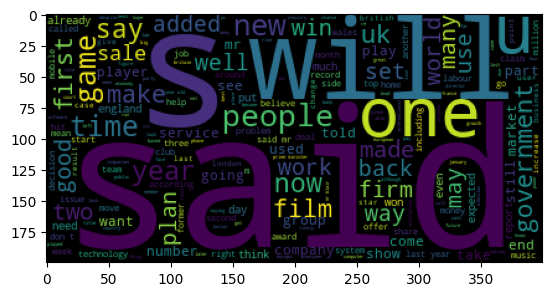

In [87]:
wc = WordCloud()
wording=train['Text']
img = wc.generate_from_text(' '.join(wording))

plt.imshow(img)

Text(0, 0.5, 'Counts')

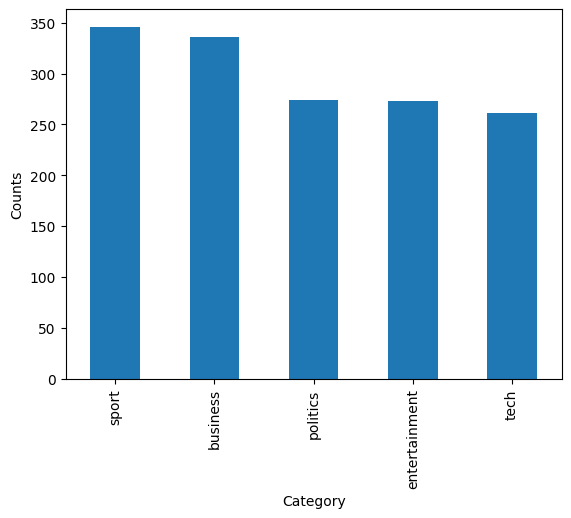

In [88]:
train.Category.value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Counts')


In [89]:
table1 = train.Category.value_counts()
table1

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [90]:
train.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [91]:
train['num_words'] = train['Text'].apply(lambda lst: len(lst))

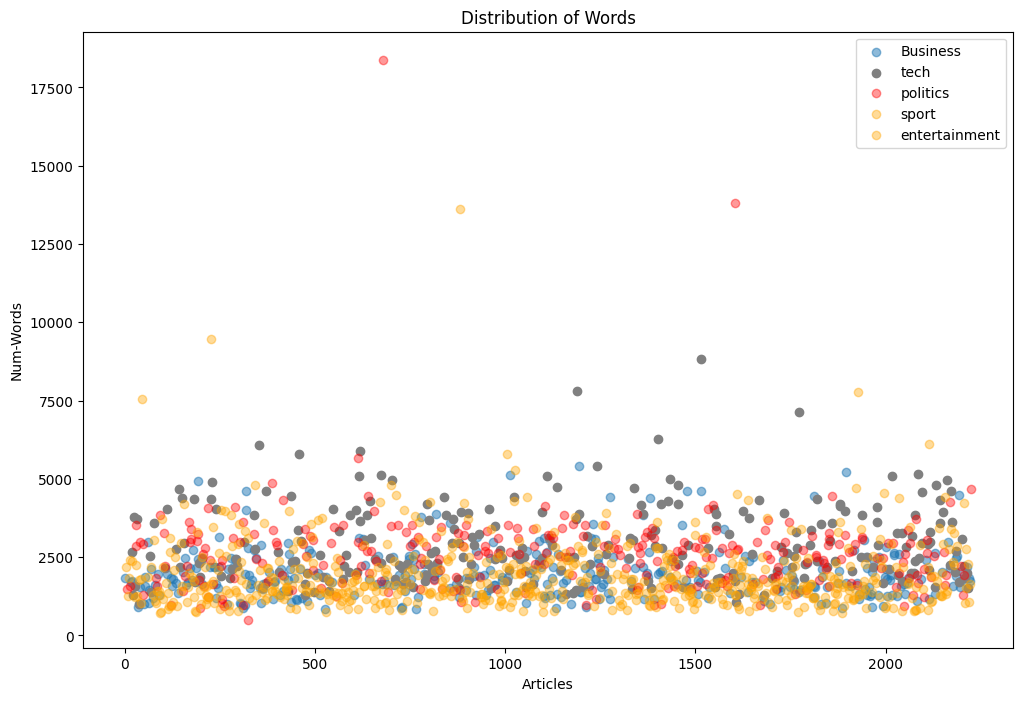

In [92]:
######
# making some visuals
business = train.loc[train['Category']=='business']
tech = train.loc[train['Category']=='tech']
politics = train.loc[train['Category']=='politics']
politics = politics.loc[politics['num_words'] <20000].reset_index(drop=True)
sport =train.loc[train['Category']=='sport']
entertainment = train.loc[train['Category']=='entertainment']

#plt.scatter(x=business['ArticleId'], y=business['num_words'],alpha=0.5)
#plt.subplot()
f, ax = plt.subplots((1),figsize = (12,8))
ax.scatter(x=business['ArticleId'], y=business['num_words'],alpha=0.5)
ax.scatter(x=tech['ArticleId'], y=tech['num_words'],color='gray')
ax.scatter(x=politics['ArticleId'], y=politics['num_words'],color='red',alpha=0.4)
ax.scatter(x=sport['ArticleId'], y=sport['num_words'],color='orange',alpha=0.4)
ax.scatter(x=entertainment['ArticleId'], y=entertainment['num_words'],color='orange',alpha=0.4)
ax.legend(['Business','tech','politics','sport','entertainment'])
plt.title("Distribution of Words")
plt.xlabel("Number of words")
plt.ylabel("Num-Words")
plt.xlabel('Articles')
plt.savefig('Plot_of_Words')

[Text(0.5, 1.0, 'Words in each category')]

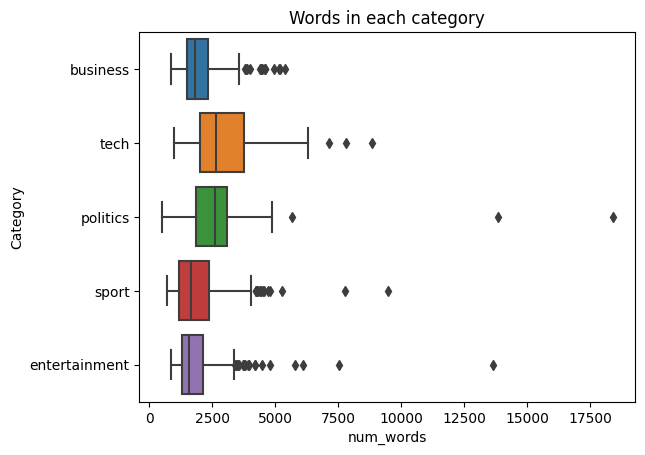

In [93]:
sns.boxplot(data = train, x = 'num_words', y = 'Category').set(title = 'Words in each category')

(array([919., 482.,  76.,   6.,   3.,   1.,   0.,   2.,   0.,   1.]),
 array([  501. ,  2289.6,  4078.2,  5866.8,  7655.4,  9444. , 11232.6,
        13021.2, 14809.8, 16598.4, 18387. ]),
 <BarContainer object of 10 artists>)

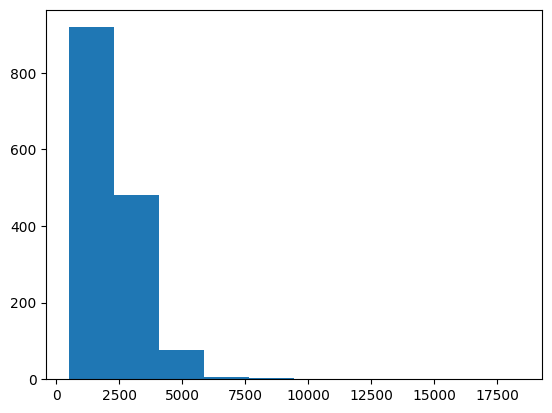

In [94]:
train['length'] = train['Text'].apply(len)
plt.hist(x=train['length'])

In [95]:
stop_words = stopwords.words('english')
train['Text'] = train['Text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
train['Text'] = train['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train['Text'] = train['Text'].apply(lambda x: re.sub(' +', ' ', x))




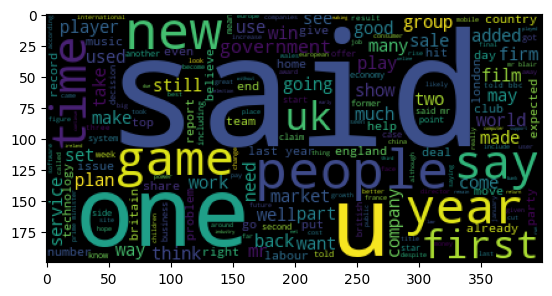

In [96]:
wc = WordCloud()
wording=train['Text']
img = wc.generate_from_text(' '.join(wording))

plt.imshow(img)

## TF-ID 
Is what I used to make my raw data into vectors. It is kind of neat really.If you look at the printout for the categories below it will look really strange at first. But it becomes quickly apperent that each number is kind of a coordinate.Using term and document frequency, term frequency is how often it appears in the document. Document frequency is just confusing. The number of documents containing that specific term. 
The TF-IDF score is frequency matrix * inverse document frequency.

In [97]:
vectorizer = TfidfVectorizer() #Convert a collection of raw documents to a matrix of TF-IDF features.
# Train and transform
train_vectors1 = vectorizer.fit_transform(train['Text'])
test_vectors1 = vectorizer.transform(test_df['Text'])
test_vectors1

<735x27107 sparse matrix of type '<class 'numpy.float64'>'
	with 112311 stored elements in Compressed Sparse Row format>

In [98]:
#print(train_vectors1)
df = pd.DataFrame(train_vectors1[0].T.todense(),
    	index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)

In [99]:
df.head()

,TF-IDF
worldcom,0.490941
accounting,0.346860
ebbers,0.342248
cooper,0.221238
fraud,0.171013


## Vectorization continued

Now for the actual project, Going to first split my data into training and test sets, then I will create a vectorizer


In [100]:
X_train, X_valid, y_train, y_valid = train_test_split(train['Text'], train['Category'], test_size=0.30, random_state=50)

In [101]:
vectorizer = TfidfVectorizer(stop_words="english", lowercase = True,decode_error ='ignore').fit(X_train)

train = vectorizer.transform(X_train)
valid = vectorizer.transform(X_valid)
tokens = vectorizer.get_feature_names_out()
train_df = pd.DataFrame(data = train.toarray(),columns = tokens)
valid_df = pd.DataFrame(data = valid.toarray(),columns = tokens)
    

In [102]:
def model(par1,par2):
	matrixm = NMF(init='nndsvdar',beta_loss = par1,solver = par2, n_components=5,max_iter =500,
    random_state=1)
	return matrixm


In [103]:

def predict(matrix):
	sortedm = np.argsort(matrix)
	n_predictions, maxval = sortedm.shape
	subjs = np.empty(n_predictions, dtype = np.int64)
	predictions = [[sortedm[i][maxval - 1]] for i in range(n_predictions)]
	for i in range(n_predictions):
		subjs[i] = predictions[i][0]
	return subjs
def label_permute(ytrue,ypred,perm_list, n=5):

	# your code here
	unique = np.unique(ytrue)
	perm = itertools.permutations(perm_list)
	accuracym = []
	for i in list(perm):
		j = 0
		ytrue_guess = ytrue
		for k in unique:
			ytrue_guess = np.where(ytrue_guess == k, i[j], ytrue_guess)
			j+=1
		pred = ytrue_guess.tolist()

		accuracy = accuracy_score(pred,ypred)
		accuracym.append((i,accuracy))
	i = 0
	max_acc = 0
	while i < len(accuracym):
		if accuracym[i][1] > max_acc:
			maxval = accuracym[i]
			max_acc = accuracym[i][1]
		i += 1
	
	
	return maxval

In [104]:
def model1(par1,par2,n):
	matrixm = NMF(init='nndsvdar',beta_loss = par1,solver = par2, n_components=5,max_iter = n,
    random_state=1)
	return matrixm



In [105]:
def model2(par1,par2,m):
	matrixm = NMF(init=m,beta_loss = par1,solver = par2, n_components=5,max_iter =1000,
    random_state=1)
	return matrixm

In [106]:
labels = [0,1,2,3,4]
m = model("frobenius", "cd").fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")

labels = [0,1,2,3,4]
m = model("frobenius", "mu").fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")


labels = [0,1,2,3,4]
m = model("kullback-leibler", "mu").fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")


31.38726983057542 That error is very high
0.9149888143176734 The permutation result is high
31.390511977396987 That error is very high
0.9194630872483222 The permutation result is high
260.33807797090435 That error is very high
0.9485458612975392 The permutation result is high


In [107]:
labels = [0,1,2,3,4]
m = model1("frobenius", "cd",500).fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")

m = model1("frobenius", "cd",1000).fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")

m = model1("frobenius", "cd",10000).fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")



31.38726983057542 That error is very high
0.9149888143176734 The permutation result is high
31.38726983057542 That error is very high
0.9149888143176734 The permutation result is high
31.38726983057542 That error is very high
0.9149888143176734 The permutation result is high


In [108]:
labels = [0,1,2,3,4]
m = model2("frobenius", "cd","random").fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")

31.387269826300408 That error is very high
0.9105145413870246 The permutation result is high


In [109]:
labels = [0,1,2,3,4]
m = model2("frobenius", "cd", 'nndsvd').fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")
labels = [0,1,2,3,4]
m = model2("frobenius", "cd", 'nndsvda').fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")

m = model2("frobenius", "cd", 'nndsvdar').fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")

31.38726982727738 That error is very high
0.9149888143176734 The permutation result is high
31.387269830512167 That error is very high
0.9149888143176734 The permutation result is high
31.38726983057542 That error is very high
0.9149888143176734 The permutation result is high


In [110]:
def modela():
	matrixm = NMF(init='nndsvdar',beta_loss = "frobenius",solver = 'cd', n_components=5,max_iter = 1000,
    random_state=1)
	return matrixm

Now To see how the model performs on test data:

In [111]:
stop_words = stopwords.words('english')
test_df['Text'] = test_df['Text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
test_df['Text'] = test_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df['Text'] = test_df['Text'].apply(lambda x: re.sub(' +', ' ', x))

In [112]:
test1 = test_df["Text"]
y_true = solution['encoded']
m = model("frobenius", "cd").fit(train)
X1 = vectorizer.transform(list(test_df['Text']))
y_hat = m.fit_transform(X1[:])

In [113]:
y_hat = np.argmax(y_hat, axis=1)
y_hat = pd.DataFrame(y_hat)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_hat)

In [114]:
y_hat = pd.DataFrame(y_hat)

In [115]:
y_hat = y_hat.rename(columns={0: "Results"})

In [116]:

df4 = y_hat['Results']
df4 = pd.DataFrame(df4)

In [117]:
df4['ArticleId'] = " "

In [118]:
df4['Category'] = " "

In [119]:
df3=solution[['ArticleId','Category']]


In [120]:
df5 = pd.concat([df3,df4],axis = 1)

In [121]:
df5.to_csv('Trying_to_do_.csv')

Okay, that went very poorly according to the results.

Now to change sampling a little bit to see if antyhing is affected.

In [122]:
train = pd.read_csv('BBCNewsTrain.csv')
test_df = pd.read_csv('BBCNewsTest.csv')
solution = pd.read_csv('BBCNewsSampleSolution.csv')
labels = {'business':0, 'tech':1, 'politics':2, 'sport':3,'entertainment':4}
solution['encoded'] = solution['Category'].map(labels)

In [123]:
stop_words = stopwords.words('english')
test_df['Text'] = test_df['Text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
test_df['Text'] = test_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df['Text'] = test_df['Text'].apply(lambda x: re.sub(' +', ' ', x))

In [124]:
X_train, X_valid, y_train, y_valid = train_test_split(train['Text'], train['Category'], test_size=0.40, random_state=50)
vectorizer = TfidfVectorizer(stop_words="english", lowercase = True,decode_error ='ignore').fit(X_train)

train = vectorizer.transform(X_train)
valid = vectorizer.transform(X_valid)
tokens = vectorizer.get_feature_names_out()
train_df = pd.DataFrame(data = train.toarray(),columns = tokens)
valid_df = pd.DataFrame(data = valid.toarray(),columns = tokens)
def model(par1,par2):
	matrixm = NMF(init='nndsvdar',beta_loss = par1,solver = par2, n_components=5,max_iter =500,
    random_state=1)
	return matrixm
def predict(matrix):
    sortedm = np.argsort(matrix)
    n_predictions, maxval = sortedm.shape
    
    predictions = [[sortedm[i][maxval - 1]] for i in range(n_predictions)]
    subjs = np.empty(n_predictions, dtype = np.int64)
    
    for i in range(n_predictions):
        subjs[i] = predictions[i][0]
    return subjs
def label_permute(ytrue,ypred,perm_list, n=5):

	# your code here
	unique = np.unique(ytrue)
	perm = itertools.permutations(perm_list)
	accuracym = []
	for i in list(perm):
		j = 0
		ytrue_guess = ytrue
		for k in unique:
			ytrue_guess = np.where(ytrue_guess == k, i[j], ytrue_guess)
			j+=1
		pred = ytrue_guess.tolist()

		accuracy = accuracy_score(pred,ypred)
		accuracym.append((i,accuracy))
	i = 0
	max_acc = 0
	while i < len(accuracym):
		if accuracym[i][1] > max_acc:
			maxval = accuracym[i]
			max_acc = accuracym[i][1]
		i += 1
	
	
	return maxval

In [125]:
labels = [0,1,2,3,4]
m = model("frobenius", "cd").fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")

29.014978303397278 That error is very high
0.9194630872483222 The permutation result is high


In [126]:
train = pd.read_csv('BBCNewsTrain.csv')
test_df = pd.read_csv('BBCNewsTest.csv')
solution = pd.read_csv('BBCNewsSampleSolution.csv')
labels = {'business':0, 'tech':1, 'politics':2, 'sport':3,'entertainment':4}
solution['encoded'] = solution['Category'].map(labels)

In [127]:
stop_words = stopwords.words('english')
test_df['Text'] = test_df['Text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
test_df['Text'] = test_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df['Text'] = test_df['Text'].apply(lambda x: re.sub(' +', ' ', x))

In [128]:
X_train, X_valid, y_train, y_valid = train_test_split(train['Text'], train['Category'], test_size=0.20, random_state=50)
vectorizer = TfidfVectorizer(stop_words="english", lowercase = True,decode_error ='ignore').fit(X_train)

train = vectorizer.transform(X_train)
valid = vectorizer.transform(X_valid)
tokens = vectorizer.get_feature_names_out()
train_df = pd.DataFrame(data = train.toarray(),columns = tokens)
valid_df = pd.DataFrame(data = valid.toarray(),columns = tokens)
def model(par1,par2):
	matrixm = NMF(init='nndsvdar',beta_loss = par1,solver = par2, n_components=5,max_iter =500,
    random_state=1)
	return matrixm
def predict(matrix):
    sortedm = np.argsort(matrix)
    n_predictions, maxval = sortedm.shape
    
    predictions = [[sortedm[i][maxval - 1]] for i in range(n_predictions)]
    subjs = np.empty(n_predictions, dtype = np.int64)
    
    for i in range(n_predictions):
        subjs[i] = predictions[i][0]
    return subjs
def label_permute(ytrue,ypred,perm_list, n=5):

	# your code here
	unique = np.unique(ytrue)
	perm = itertools.permutations(perm_list)
	accuracym = []
	for i in list(perm):
		j = 0
		ytrue_guess = ytrue
		for k in unique:
			ytrue_guess = np.where(ytrue_guess == k, i[j], ytrue_guess)
			j+=1
		pred = ytrue_guess.tolist()

		accuracy = accuracy_score(pred,ypred)
		accuracym.append((i,accuracy))
	i = 0
	max_acc = 0
	while i < len(accuracym):
		if accuracym[i][1] > max_acc:
			maxval = accuracym[i]
			max_acc = accuracym[i][1]
		i += 1
	
	
	return maxval

In [129]:
labels = [0,1,2,3,4]
m = model("frobenius", "cd").fit(train)

print(m.reconstruction_err_,"That error is very high")
y_pred = predict(m.transform(valid))
label_order, accuracy = label_permute(y_valid, y_pred,labels,'Permutation result')
print(accuracy, "The permutation result is high")

33.52124201541025 That error is very high
0.9026845637583892 The permutation result is high


Okay enough of that. I will just sit here all day messing with stuff I am going to just move on now. Lets do my favorite. Tried and true linear SVM. Great for classifying things into categories. Which this kind of is. We are taking text and predicting what category it is is based on some patterns.

In [47]:
train = pd.read_csv('BBCNewsTrain.csv')
test_df = pd.read_csv('BBCNewsTest.csv')
solution = pd.read_csv('BBCNewsSampleSolution.csv')
labels = {'business':0, 'tech':1, 'politics':2, 'sport':3,'entertainment':4}
solution['encoded'] = solution['Category'].map(labels)
stop_words = stopwords.words('english')
train['Text'] = train['Text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
train['Text'] = train['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train['Text'] = train['Text'].apply(lambda x: re.sub(' +', ' ', x))
test_df['Text'] = test_df['Text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
test_df['Text'] = test_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df['Text'] = test_df['Text'].apply(lambda x: re.sub(' +', ' ', x))


In [48]:
def autosplit(data,n):
    train1, test1 = train_test_split(data, test_size=n)
    return train1,test1

In [49]:
train1, test1 = autosplit(train,0.1)


In [50]:
from sklearn import svm
def running(func):
	vectorizer = TfidfVectorizer()
	train_vectors1 = vectorizer.fit_transform(train1['Text'])
	test_vectors1 = vectorizer.transform(test1['Text'])
	classifier_linear = svm.SVC(kernel='linear')
	classifier_linear.fit(train_vectors1, train1['Category'])
	prediction_linear = classifier_linear.predict(test_vectors1)
	y_pred=prediction_linear
	y_true=test1['Category']
	report = classification_report(y_true, y_pred, output_dict=True)
	report = pd.DataFrame(report)
	return report
	print("param change sample size")
	report

In [51]:
(running(autosplit(train,0.1)))

,business,entertainment,politics,sport,tech,accuracy,macro avg,weighted avg
precision,1.000000,0.944444,0.896552,0.974359,0.962963,0.959732,0.955664,0.962111
recall,0.900000,1.000000,1.000000,1.000000,0.928571,0.959732,0.965714,0.959732
f1-score,0.947368,0.971429,0.945455,0.987013,0.945455,0.959732,0.959344,0.959531
support,40.000000,17.000000,26.000000,38.000000,28.000000,0.959732,149.000000,149.000000


In [52]:
(running(autosplit(train,0.2)))

,business,entertainment,politics,sport,tech,accuracy,macro avg,weighted avg
precision,1.000000,0.944444,0.896552,0.974359,0.962963,0.959732,0.955664,0.962111
recall,0.900000,1.000000,1.000000,1.000000,0.928571,0.959732,0.965714,0.959732
f1-score,0.947368,0.971429,0.945455,0.987013,0.945455,0.959732,0.959344,0.959531
support,40.000000,17.000000,26.000000,38.000000,28.000000,0.959732,149.000000,149.000000


In [53]:
(running(autosplit(train,0.3)))

,business,entertainment,politics,sport,tech,accuracy,macro avg,weighted avg
precision,1.000000,0.944444,0.896552,0.974359,0.962963,0.959732,0.955664,0.962111
recall,0.900000,1.000000,1.000000,1.000000,0.928571,0.959732,0.965714,0.959732
f1-score,0.947368,0.971429,0.945455,0.987013,0.945455,0.959732,0.959344,0.959531
support,40.000000,17.000000,26.000000,38.000000,28.000000,0.959732,149.000000,149.000000


My model did really well. I am surprised, figuring by the way the assignment was worded I figured every model would do really poorly. But the performance of this model was excellent. I am pleasantly surprised and confused. 

In [54]:
category = train['Category']
text = train['Text']

In [55]:
def splits(n):
	X_train, X_test, Y_train, Y_test = train_test_split(text,category, test_size = n, random_state = 60,shuffle=True, stratify=category)
	return X_train, X_test, Y_train, Y_test 

In [56]:
X_train, X_test, Y_train, Y_test = splits(0.1)

In [58]:
from sklearn.tree import DecisionTreeClassifier
vectorizer = TfidfVectorizer(stop_words="english", lowercase = True,decode_error ='ignore').fit(train1)

train2 = vectorizer.transform(train1['Text'])
valid2 = vectorizer.transform(test1['Text'])

sorta = np.argmax(train2,axis=1)
labels_ = np.argmax(train2,axis=0)
from sklearn.pipeline  import Pipeline
clf = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),])
fitting = clf.fit(X_train,Y_train)
predicitontime = clf.predict(X_test)
clf.score(X_train,Y_train)
accuracy_score(predicitontime, Y_test)

0.7651006711409396

In [59]:
X_train, X_test, Y_train, Y_test = splits(0.2)
vectorizer = TfidfVectorizer(stop_words="english", lowercase = True,decode_error ='ignore').fit(train1)

train2 = vectorizer.transform(train1['Text'])
valid2 = vectorizer.transform(test1['Text'])

sorta = np.argmax(train2,axis=1)
labels_ = np.argmax(train2,axis=0)
from sklearn.pipeline  import Pipeline
clf = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),])
fitting = clf.fit(X_train,Y_train)
predicitontime = clf.predict(X_test)
clf.score(X_train,Y_train)
accuracy_score(predicitontime, Y_test)
reporting = (classification_report(predicitontime, Y_test))
print(reporting)

               precision    recall  f1-score   support

     business       0.75      0.74      0.74        68
entertainment       0.76      0.76      0.76        55
     politics       0.85      0.76      0.80        62
        sport       0.88      0.87      0.88        70
         tech       0.71      0.86      0.78        43

     accuracy                           0.80       298
    macro avg       0.79      0.80      0.79       298
 weighted avg       0.80      0.80      0.80       298



In [60]:
X_train, X_test, Y_train, Y_test = splits(0.30)
vectorizer = TfidfVectorizer(stop_words="english", lowercase = True,decode_error ='ignore').fit(train1)

train2 = vectorizer.transform(train1['Text'])
valid2 = vectorizer.transform(test1['Text'])

sorta = np.argmax(train2,axis=1)
labels_ = np.argmax(train2,axis=0)
from sklearn.pipeline  import Pipeline
clf = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),])
fitting = clf.fit(X_train,Y_train)
predicitontime = clf.predict(X_test)
clf.score(X_train,Y_train)
accuracy_score(predicitontime, Y_test)
reporting = (classification_report(predicitontime, Y_test))
print(reporting)

               precision    recall  f1-score   support

     business       0.81      0.77      0.79       106
entertainment       0.78      0.83      0.81        77
     politics       0.80      0.82      0.81        80
        sport       0.89      0.89      0.89       105
         tech       0.83      0.82      0.83        79

     accuracy                           0.83       447
    macro avg       0.82      0.83      0.83       447
 weighted avg       0.83      0.83      0.83       447



In [61]:
X_train, X_test, Y_train, Y_test = splits(0.40)
vectorizer = TfidfVectorizer(stop_words="english", lowercase = True,decode_error ='ignore').fit(train1)

train2 = vectorizer.transform(train1['Text'])
valid2 = vectorizer.transform(test1['Text'])

sorta = np.argmax(train2,axis=1)
labels_ = np.argmax(train2,axis=0)
from sklearn.pipeline  import Pipeline
clf = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),])
fitting = clf.fit(X_train,Y_train)
predicitontime = clf.predict(X_test)
clf.score(X_train,Y_train)
accuracy_score(predicitontime, Y_test)
reporting = (classification_report(predicitontime, Y_test))
print(reporting)

               precision    recall  f1-score   support

     business       0.75      0.79      0.77       127
entertainment       0.74      0.84      0.79        97
     politics       0.83      0.83      0.83       109
        sport       0.87      0.78      0.82       155
         tech       0.78      0.75      0.76       108

     accuracy                           0.80       596
    macro avg       0.79      0.80      0.79       596
 weighted avg       0.80      0.80      0.80       596



So my model did pretty okay on the training and test data. It could be better but it did not do too badly. 

In [62]:
from sklearn.pipeline  import Pipeline
clf = Pipeline([('tfidf', TfidfVectorizer(input='content',
    					decode_error='ignore',
                          norm = 'l2',
                          stop_words = 'english',
                          analyzer='char_wb' # Added Strip accents -asc
    
    )),
                ('dt', DecisionTreeClassifier()),])


In [63]:
fitting = clf.fit(X_train,Y_train)
predicitontime = clf.predict(X_test)
clf.score(X_train,Y_train)
accuracy_score(predicitontime, Y_test)
labels
labels1=train['Category'].unique()
reporting = (classification_report(predicitontime, Y_test))

c:\gitfiles\Lib\site-packages\sklearn\feature_extraction\text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [64]:
print(reporting)

               precision    recall  f1-score   support

     business       0.40      0.46      0.43       117
entertainment       0.42      0.43      0.43       106
     politics       0.43      0.41      0.42       114
        sport       0.53      0.51      0.52       146
         tech       0.45      0.42      0.43       113

     accuracy                           0.45       596
    macro avg       0.45      0.45      0.45       596
 weighted avg       0.45      0.45      0.45       596



In [65]:
from sklearn.pipeline  import Pipeline
clf = Pipeline([('tfidf', TfidfVectorizer(
    					decode_error='ignore',
                           # Added Strip accents -asc
                           )),
                ('dt', DecisionTreeClassifier(random_state=25,criterion='entropy',max_depth = 70)),])

In [66]:
fitting = clf.fit(X_train,Y_train)
predicitontime = clf.predict(X_test)
clf.score(X_train,Y_train)
accuracy_score(predicitontime, Y_test)
labels
labels1=train['Category'].unique()
reporting = (classification_report(predicitontime, Y_test))

In [67]:
print(reporting)


               precision    recall  f1-score   support

     business       0.78      0.71      0.75       147
entertainment       0.64      0.81      0.72        86
     politics       0.78      0.76      0.77       113
        sport       0.94      0.83      0.88       157
         tech       0.69      0.77      0.73        93

     accuracy                           0.78       596
    macro avg       0.77      0.78      0.77       596
 weighted avg       0.79      0.78      0.78       596



In [72]:
from sklearn.metrics import confusion_matrix
matrixs=confusion_matrix(predicitontime, Y_test)

<AxesSubplot: >

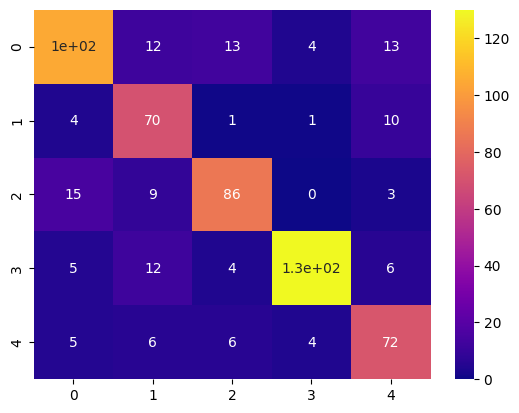

In [70]:
sns.heatmap(matrixs,annot = True,cmap ='plasma' )